In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import calendar
from utils import *
import quantstats as qs
import scipy
from sklearn.linear_model import LinearRegression

In [2]:
# TODO
# Validate growth rate calculations
# Validate up/down capture rate
# Validate win rate
# Validate Jensen's alpha
# Validate Calmar ratio (Validated)
# Validate Treynor ratio
# Validate Sortino ratio
# Validate Sharpe ratio
# Validate Information ratio (Validated)
# Validate STD of Fund returns (Validated)
# Validate alpha and beta of the fund (Validated)
# Validate MPPM (Validated)
# Update all the beta calculations with respect to risk free rate
# Validate CRP Ratio (Validated)
# Validate payoff ratio
# validate Turnover rate
# Validate Average holding time


# NOTES
# 1. FOr treynor ratio and sharpe ratio, quant stats only accepts a single float. Is it ok?
# 2. Yizhi Zhang got the downside deviation's formula wrong. The denominator has to be the count of all the entries, not the times than return was less than MAR
# 3. The indian student, when calculating rho for the MPPM metric, hasn't used np.log(), Not in numerator or denominator 
# 4. When calculating the MPPM, the indian student hasn't used np.log as well

The entire date range is from 2019-12-27 00:00:00 to 2023-10-31 00:00:00 (1404 days 00:00:00)


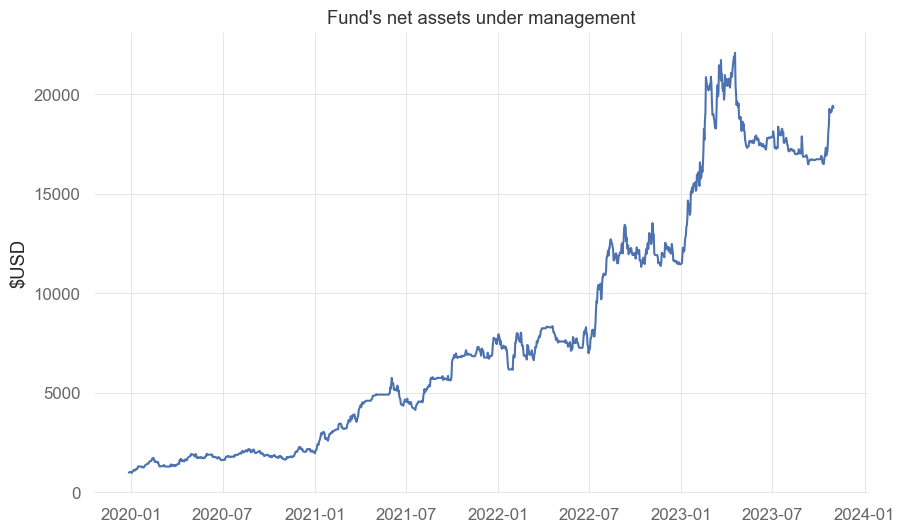

In [3]:
# Data and super variables
# Import the data for fund 1
f1_DailyAuM = pd.read_csv("./Data/Daily AuM - AuM (1).csv")
f1_DailyTrades = pd.read_csv("./Data/Daily AuM - Trades_10.csv")


# Get the union of both datasets (Date-wise)
f1_DailyAuM.Date = pd.to_datetime(f1_DailyAuM.Date, dayfirst = True, format = "mixed")
f1_DailyTrades.buy_date = pd.to_datetime(f1_DailyTrades.buy_date, dayfirst = True, format = "mixed")
f1_DailyTrades.sell_date = pd.to_datetime(f1_DailyTrades.sell_date, dayfirst = True, format = "mixed")

f1_DailyTrades_LastDate = f1_DailyTrades.iloc[-1].sell_date
f1_DailyAuM_LastDate = f1_DailyAuM.iloc[-1].Date

if f1_DailyTrades_LastDate < f1_DailyAuM_LastDate:
    f1_DailyAuM = f1_DailyAuM[f1_DailyAuM.Date <= f1_DailyTrades_LastDate]
else:
    f1_DailyTrades = f1_DailyTrades[f1_DailyTrades.sell_date <= f1_DailyAuM_LastDate]

# start and end of date of the entire dataset
START_DATE, END_DATE = f1_DailyAuM.iloc[0].Date, f1_DailyAuM.iloc[-1].Date 
START_MONTH, END_MONTH = f1_DailyAuM.iloc[0].Date.month, f1_DailyAuM.iloc[-1].Date.month 
START_YEAR, END_YEAR = f1_DailyAuM.iloc[0].Date.year, f1_DailyAuM.iloc[-1].Date.year 



# Import BTC data as a benchmark
btcData = loadBTCReturn("./Data/Bitcoin-Historical-Data.csv")
btcData =  btcData[(START_DATE <= btcData.Date)&(btcData.Date <= END_DATE)].reset_index(drop=True)

# Import barclay hedge index as a benchmark
barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
barclayReturns = barclayReturns[(START_DATE <= barclayReturns.Date)&(barclayReturns.Date <= END_DATE)].reset_index(drop=True)

print(f"The entire date range is from {START_DATE} to {END_DATE} ({(f1_DailyAuM.iloc[-1].Date - f1_DailyAuM.iloc[0].Date)})")

plt.plot(f1_DailyAuM.Date, f1_DailyAuM.AuM); plt.title("Fund's net assets under management"); plt.ylabel("$USD"); plt.show()

Rolling growth rate


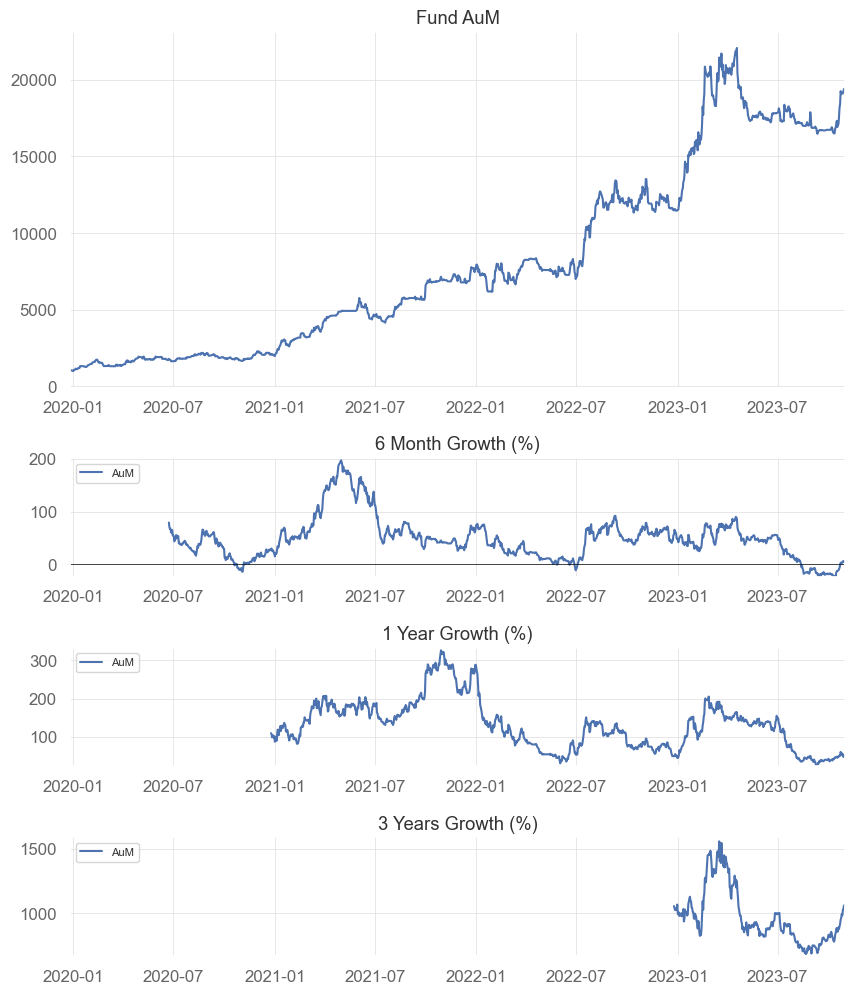

In [4]:
# Rolling growth rate
# Derived from growth rate formula in previous cell
print("Rolling growth rate")
return_6M = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 180)).dropna()
return_1Y = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 365)).dropna()
return_3Y = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 365*3)).dropna()

subPlots = [return_6M,return_1Y,return_3Y]
plotTitle = ["Fund AuM", "6 Month Growth (%)", "1 Year Growth (%)", "3 Years Growth (%)"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [7]:
# Up/Down capture return
# Getting the monthly return of the Fund's AuM
print("Metric: Up/Down capture return (Relative to Barclay hedge index)")
for i in [[6, "months"]]: # , [1, "years"], [3, "years"]
    fundReturns = getMonthlyReturns(f1_DailyAuM)
    barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
    barclayReturns = barclayReturns[(START_DATE <= barclayReturns.Date)&(barclayReturns.Date <= END_DATE)].reset_index(drop=True)

    df = pd.concat([fundReturns.Date, fundReturns.fundReturn, barclayReturns.barclayReturn], axis = 1)
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Up capture
    upDf = dfCumulativeReturn[0 <= dfCumulativeReturn.barclayReturn]
    upCapture = calcCaptureRate(upDf[["fundReturn", "barclayReturn"]])
    # Down capture
    dnDf = dfCumulativeReturn[dfCumulativeReturn.barclayReturn <= 0]
    dnCapture = calcCaptureRate(dnDf[["fundReturn", "barclayReturn"]])

    print(f"{i[0]} {i[1]}:        up capture rate: {upCapture}   |    down capture rate: {dnCapture}")

Metric: Up/Down capture return (Relative to Barclay hedge index)
6 months:        up capture rate: -7.741147552292304   |    down capture rate: 0.5050101968620927


Metric: Rolling Up/Down capture return (Relative to BTC)


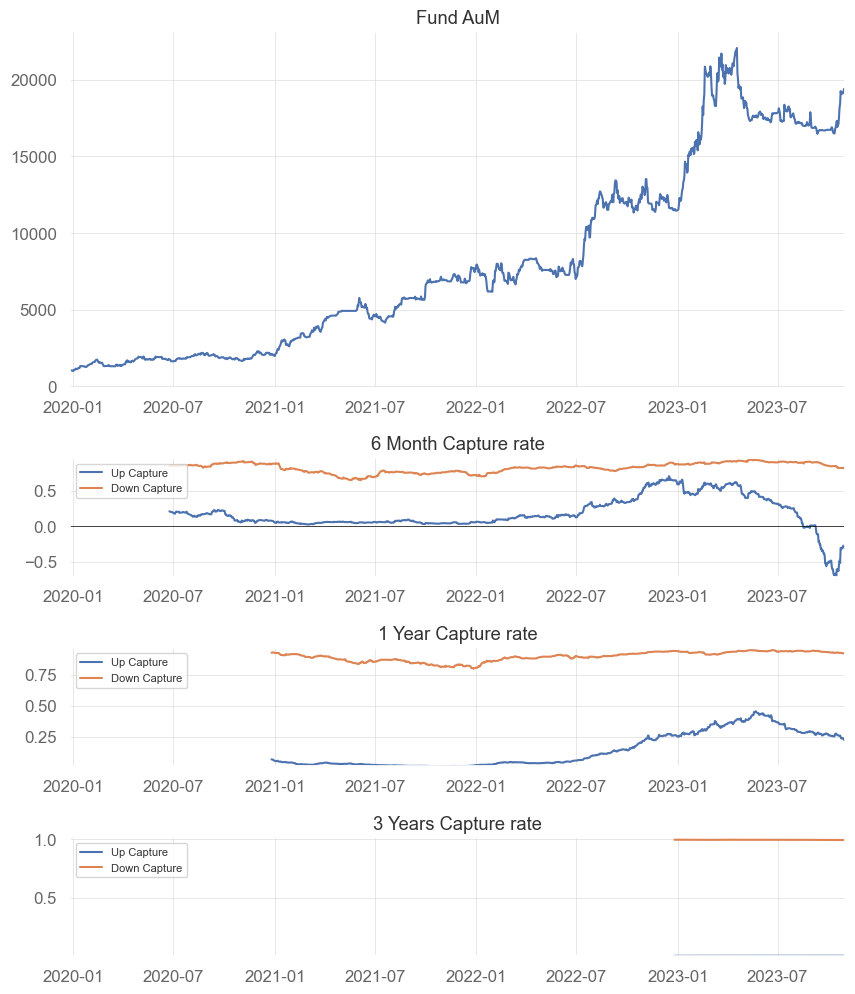

In [8]:
# Rolling up/Down capture ratio
print("Metric: Rolling Up/Down capture return (Relative to BTC)")

# Get the daily return of fund and BTC
df = pd.concat([f1_DailyAuM.Date, f1_DailyAuM.AuM, btcData.Price], axis = 1).set_index("Date")
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark"]

upCapture_6M, downCapture_6M = calcRollingCaptureRate(dfReturn, datetime.timedelta(days = 180))
upCapture_1Y, downCapture_1Y = calcRollingCaptureRate(dfReturn, datetime.timedelta(days = 365))
upCapture_3Y, downCapture_3Y = calcRollingCaptureRate(dfReturn, datetime.timedelta(days = 365*3))

# process the results to feed them into plotter method
capture_6M = pd.concat([upCapture_6M.iloc[:,0],downCapture_6M.iloc[:,0]], axis = 1).dropna()
capture_6M.columns = ["Up Capture", "Down Capture"]

capture_1Y = pd.concat([upCapture_1Y.iloc[:,0],downCapture_1Y.iloc[:,0]], axis = 1).dropna()
capture_1Y.columns = ["Up Capture", "Down Capture"]

capture_3Y = pd.concat([upCapture_3Y.iloc[:,0],downCapture_3Y.iloc[:,0]], axis = 1).dropna()
capture_3Y.columns = ["Up Capture", "Down Capture"]

# Plot the rolling capture rate
subPlots = [capture_6M,capture_1Y,capture_3Y]
plotTitle = ["Fund AuM", "6 Month Capture rate", "1 Year Capture rate", "3 Years Capture rate"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [7]:
# Win rate
print("Metric: Win rate")
fundReturns = getMonthlyReturns(f1_DailyAuM).sort_values("Date", ascending=False)
tmp =fundReturns.iloc[0:6,:]
winrate = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"6 months win rate: {winrate}")

tmp =fundReturns.iloc[0:12,:]
winrate = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"1 year win rate: {winrate}")

tmp =fundReturns.iloc[0:36,:]
winrate = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"3 years win rate: {winrate}")

Metric: Win rate
6 months win rate: 0.3333333333333333
1 year win rate: 0.3333333333333333
3 years win rate: 0.6111111111111112


Metric: Rolling Win rate


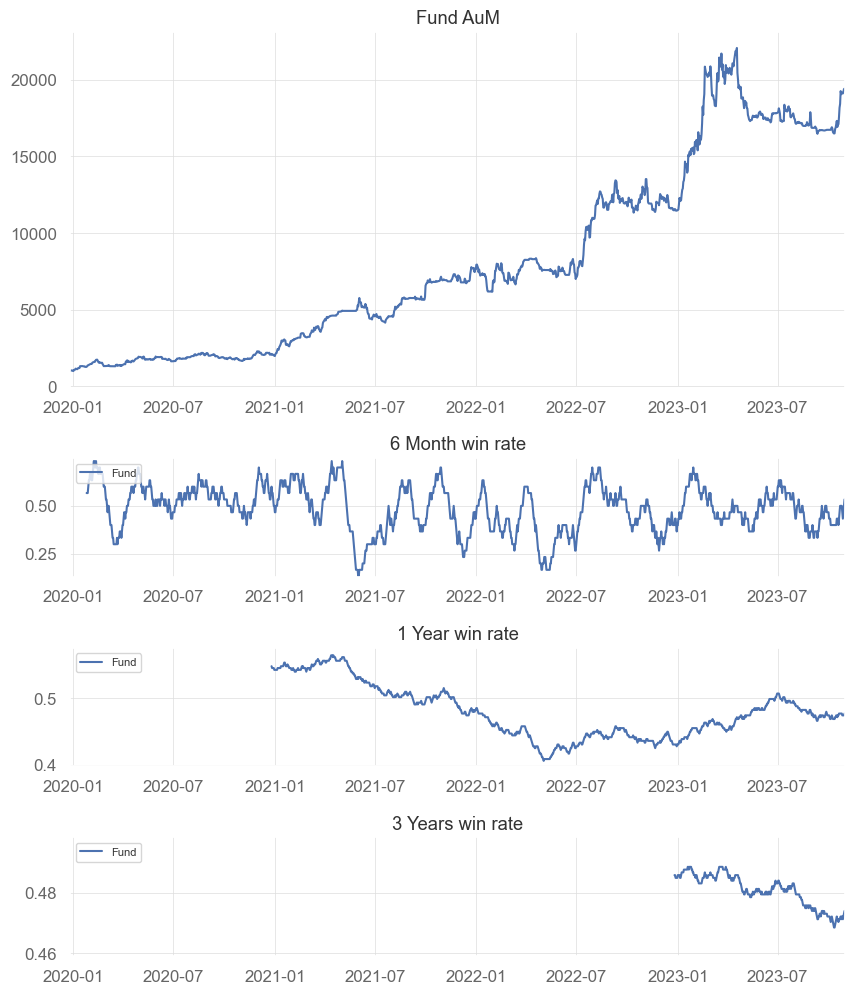

In [8]:
# Rolling win rate
# Get the daily return of fund and BTC
print("Metric: Rolling Win rate")

# Process the input data, only the fund AuM is required
df = f1_DailyAuM.set_index("Date")
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund"]

# Calculate the rolling win rates
winRate_6M = calcRollingWinRate(dfReturn, datetime.timedelta(30))
winRate_1Y = calcRollingWinRate(dfReturn, datetime.timedelta(365))
winRate_3Y = calcRollingWinRate(dfReturn, datetime.timedelta(365*3))

# Plot the rolling win rates
subPlots = [winRate_6M,winRate_1Y,winRate_3Y]
plotTitle = ["Fund AuM", "6 Month win rate", "1 Year win rate", "3 Years win rate"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [9]:
# Jensen's alpha
print("Metric: Jensen's alpha (Relative to Barclay hedge index)")
fundReturns = getMonthlyReturns(f1_DailyAuM)
fundReturns =  fundReturns[(START_DATE <= fundReturns.Date)&(fundReturns.Date <= END_DATE)].reset_index(drop=True)
barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
barclayReturns = barclayReturns[(START_DATE <= barclayReturns.Date)&(barclayReturns.Date <= END_DATE)].reset_index(drop=True)
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv")
rfReturn = getMonthlyReturns(rfReturn[["Date","Price"]], ["Date", "rfReturn"])
rfReturn = rfReturn[(START_DATE <= rfReturn.Date)&(rfReturn.Date <= END_DATE)].reset_index(drop=True)

# Merge all data together 
df = pd.concat([fundReturns.Date, fundReturns.fundReturn, barclayReturns.barclayReturn, rfReturn.rfReturn], axis = 1)

# Run the code in a loop to get the results for 6months, 1 year and 3 years periods
tmp = pd.DataFrame(columns=["intervalStart","intervalEnd","fundReturn","barclayReturn","rfReturn","beta","jensenAlpha"])
for i in [[6, "months"], [1, "years"], [3, "years"]]:
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Calculate beta for each interval
    dfCumulativeReturn["beta"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        tempFund = fundReturns[(row.intervalStart<=fundReturns.Date)&(fundReturns.Date<=row.intervalEnd)]
        tempBenchmark = barclayReturns[(row.intervalStart<=barclayReturns.Date)&(barclayReturns.Date<=row.intervalEnd)]
        dfCumulativeReturn.iloc[i,-1] = calc_beta(tempFund.fundReturn, tempBenchmark.barclayReturn)

    # Calculate Jensen's alpha for each interval
    dfCumulativeReturn["jensenAlpha"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        alpha = calcJensenAlpha(row.fundReturn, row.barclayReturn, row.rfReturn, row.beta)
        dfCumulativeReturn.iloc[i,-1] = alpha
    
    tmp = pd.concat([tmp if not tmp.empty else None, dfCumulativeReturn])

tmp.index = ["6 months"]*7  + ["1 year"]*3 + ["3 years"]
tmp.style.set_caption("Jensen's alpha")

Metric: Jensen's alpha (Relative to Barclay hedge index)


,intervalStart,intervalEnd,fundReturn,barclayReturn,rfReturn,beta,jensenAlpha
6 months,2023-04-01 00:00:00,2023-09-30 00:00:00,-0.166019,0.017244,-0.020875,1.478143,-0.201489
6 months,2022-10-01 00:00:00,2023-03-31 00:00:00,0.652258,0.058794,0.355862,-4.566940,-1.060295
6 months,2022-04-01 00:00:00,2022-09-30 00:00:00,0.624562,-0.086267,1.087427,-0.473041,-1.018070
6 months,2021-10-01 00:00:00,2022-03-31 00:00:00,0.087364,-0.016365,1.203668,0.160959,-0.919929
6 months,2021-04-01 00:00:00,2021-09-30 00:00:00,0.801733,0.037809,0.256576,3.984646,1.416865
6 months,2020-10-01 00:00:00,2021-03-31 00:00:00,0.534736,0.145525,1.610394,2.579686,2.703243
6 months,2020-04-01 00:00:00,2020-09-30 00:00:00,0.539160,0.153922,-0.740993,-0.990669,2.166719
1 year,2022-10-01 00:00:00,2023-09-30 00:00:00,0.377952,0.077052,0.327558,-1.666648,-0.367113
1 year,2021-10-01 00:00:00,2022-09-30 00:00:00,0.766490,-0.101220,3.599997,-0.884519,-6.107305
1 year,2020-10-01 00:00:00,2021-09-30 00:00:00,1.765184,0.188836,2.280157,1.992856,3.652729


Metric: Rolling Jensen's alpha (Relative to BTC as benchmark)


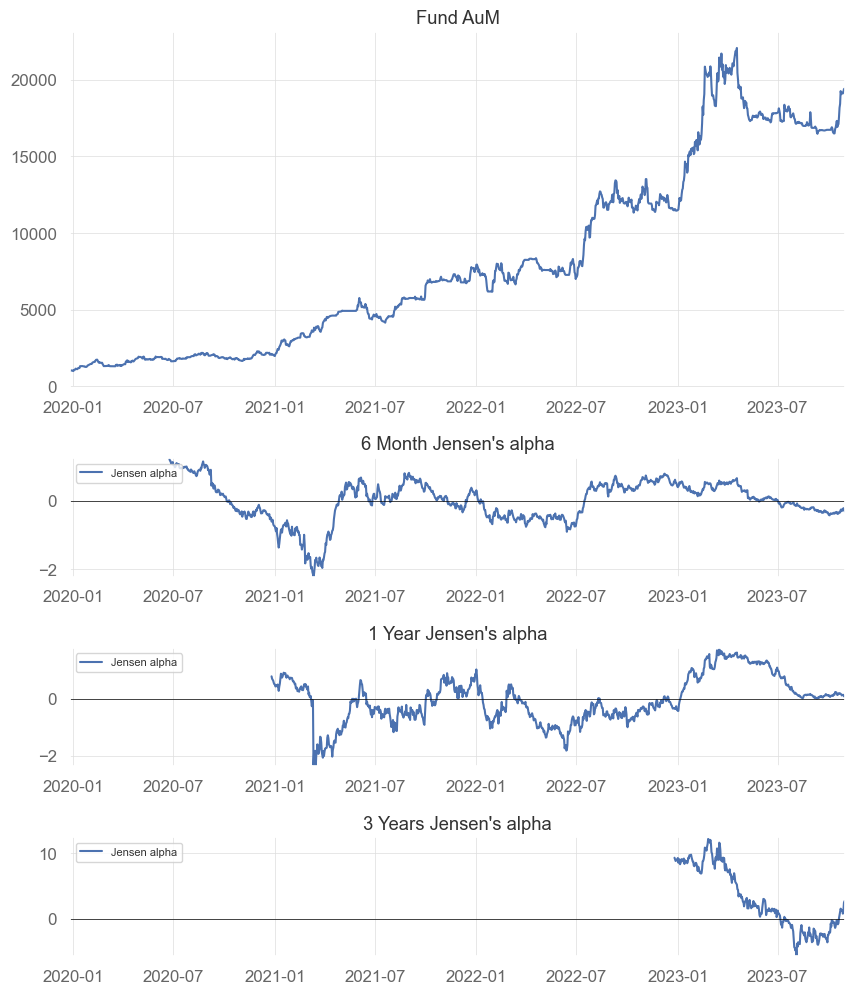

In [10]:
# Rolling jensen ratio
print("Metric: Rolling Jensen's alpha (Relative to BTC as benchmark)")

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")
btcDailyData = btcData.set_index("Date")

# Merge the data
df = pd.concat([fundDailyData.AuM, btcDailyData.Price, rfReturn.Price], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark", "RiskFreeReturn"]

jensenAlpha_6M = rollingJensenAlpha(dfReturn,datetime.timedelta(180))
jensenAlpha_1Y = rollingJensenAlpha(dfReturn,datetime.timedelta(365))
jensenAlpha_3Y = rollingJensenAlpha(dfReturn,datetime.timedelta(3*365))

# Plot the rolling Jensen's alpha
subPlots = [jensenAlpha_6M,jensenAlpha_1Y,jensenAlpha_3Y]
plotTitle = ["Fund AuM", "6 Month Jensen's alpha", "1 Year Jensen's alpha", "3 Years Jensen's alpha"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [11]:
# Calmar ratio
print("Metric: Calmar ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM)

# Note, to use quanstats, the Date column has to be dataframe's index column
fundReturns =  fundReturns[(START_DATE <= fundReturns.Date)&(fundReturns.Date <= END_DATE)].reset_index(drop=True).set_index("Date")

# 6 months
calmar = qs.stats.calmar(fundReturns.iloc[-7:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

# 1 year
calmar = qs.stats.calmar(fundReturns.iloc[-13:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

# 3 years
calmar = qs.stats.calmar(fundReturns.iloc[-37:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

Metric: Calmar ratio
6 months calmar ratio: -1.597221101868814
6 months calmar ratio: 1.642781430337797
6 months calmar ratio: 3.4341676010729554


Metric: Rolling Calmar ratio


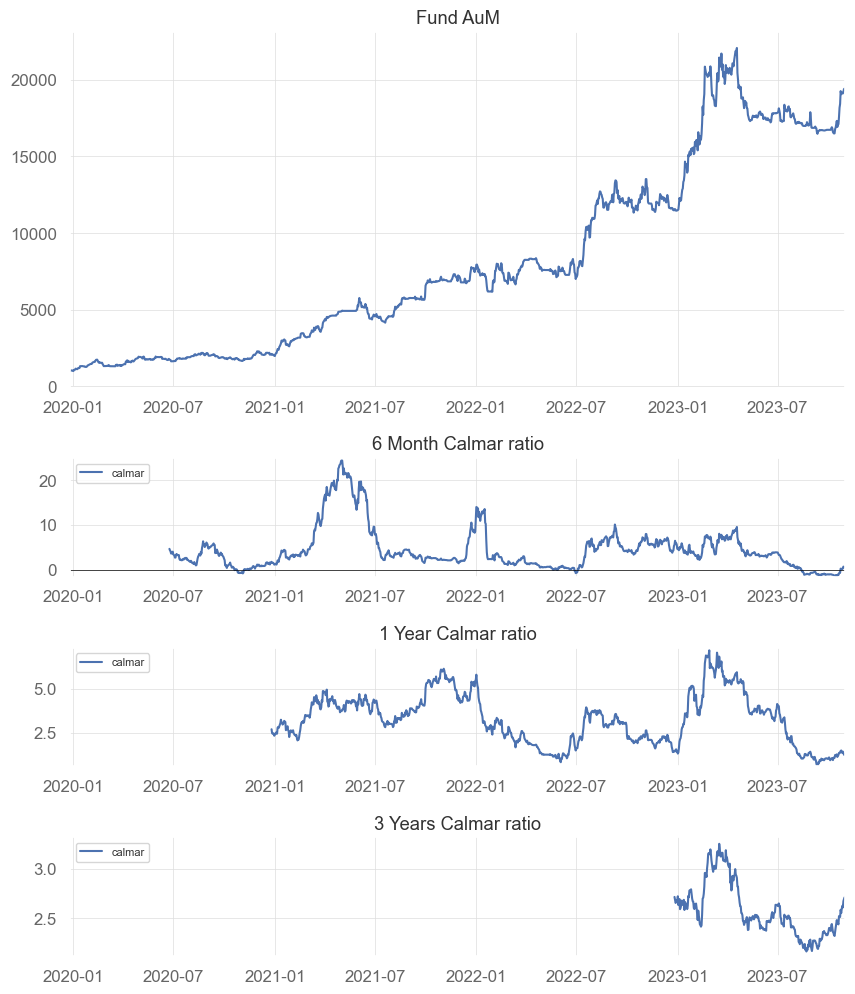

In [12]:
# Rolling Calmar ratio
print("Metric: Rolling Calmar ratio")
fundDailyData = f1_DailyAuM.set_index("Date").pct_change(1).dropna()

calmar_6M = calcRollingCalmarRatio(fundDailyData, datetime.timedelta(180))
calmar_1Y = calcRollingCalmarRatio(fundDailyData, datetime.timedelta(365))
calmar_3Y = calcRollingCalmarRatio(fundDailyData, datetime.timedelta(365*3))

# Plot the rolling Calmar ratio
subPlots = [calmar_6M,calmar_1Y,calmar_3Y]
plotTitle = ["Fund AuM", "6 Month Calmar ratio", "1 Year Calmar ratio", "3 Years Calmar ratio"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [13]:
# Treynor ratio
print("Metric: Treynor ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM)
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv")
rfReturn = getMonthlyReturns(rfReturn[["Date","Price"]], ["Date", "rfReturn"])
rfReturn = rfReturn[(START_DATE <= rfReturn.Date)&(rfReturn.Date <= END_DATE)].reset_index(drop=True)

# Merge all data together 
df = pd.concat([fundReturns.Date, fundReturns.fundReturn, rfReturn.rfReturn], axis = 1)

# Run the code in a loop to get the results for 6months, 1 year and 3 years periods
tmp = pd.DataFrame(columns=["intervalStart","intervalEnd","fundReturn","barclayReturn","rfReturn","beta","TreynorRatio"])
for i in [[6, "months"], [1, "years"], [3, "years"]]:
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Calculate beta for each interval
    dfCumulativeReturn["beta"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        tempFund = fundReturns[(row.intervalStart<=fundReturns.Date)&(fundReturns.Date<=row.intervalEnd)]
        tempBenchmark = barclayReturns[(row.intervalStart<=barclayReturns.Date)&(barclayReturns.Date<=row.intervalEnd)]
        dfCumulativeReturn.iloc[i,-1] = calc_beta(tempFund.fundReturn, tempBenchmark.barclayReturn)

    # Calculate Treynor ratio for each interval
    dfCumulativeReturn["TreynorRatio"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        alpha = calcTreynorRatio(row.fundReturn, row.rfReturn, row.beta)
        dfCumulativeReturn.iloc[i,-1] = alpha
    
    tmp = pd.concat([tmp if not tmp.empty else None, dfCumulativeReturn])

tmp.index = ["6 months"]*7  + ["1 year"]*3 + ["3 years"]
tmp.style.set_caption('Treynor Ratio')


Metric: Treynor ratio


,intervalStart,intervalEnd,fundReturn,rfReturn,beta,TreynorRatio
6 months,2023-05-01 00:00:00,2023-10-31 00:00:00,-0.167980,0.249906,0.773379,-0.540338
6 months,2022-11-01 00:00:00,2023-04-30 00:00:00,0.649983,-0.049477,-3.994652,-0.175099
6 months,2022-05-01 00:00:00,2022-10-31 00:00:00,0.451293,0.596280,-1.051167,0.137929
6 months,2021-11-01 00:00:00,2022-04-30 00:00:00,0.195608,1.765069,-0.966066,1.624591
6 months,2021-05-01 00:00:00,2021-10-31 00:00:00,0.373640,0.170035,-4.764854,-0.042731
6 months,2020-11-01 00:00:00,2021-04-30 00:00:00,1.343934,2.217724,-1.260456,0.693233
6 months,2020-05-01 00:00:00,2020-10-31 00:00:00,0.279866,-0.297100,2.712330,0.212720
1 year,2022-11-01 00:00:00,2023-10-31 00:00:00,0.372819,0.188065,-1.129253,-0.163607
1 year,2021-11-01 00:00:00,2022-10-31 00:00:00,0.735178,3.413826,-0.981445,2.729291
1 year,2020-11-01 00:00:00,2021-10-31 00:00:00,2.219721,2.764849,0.965702,-0.564488


Metric: Rolling Treynor ratio


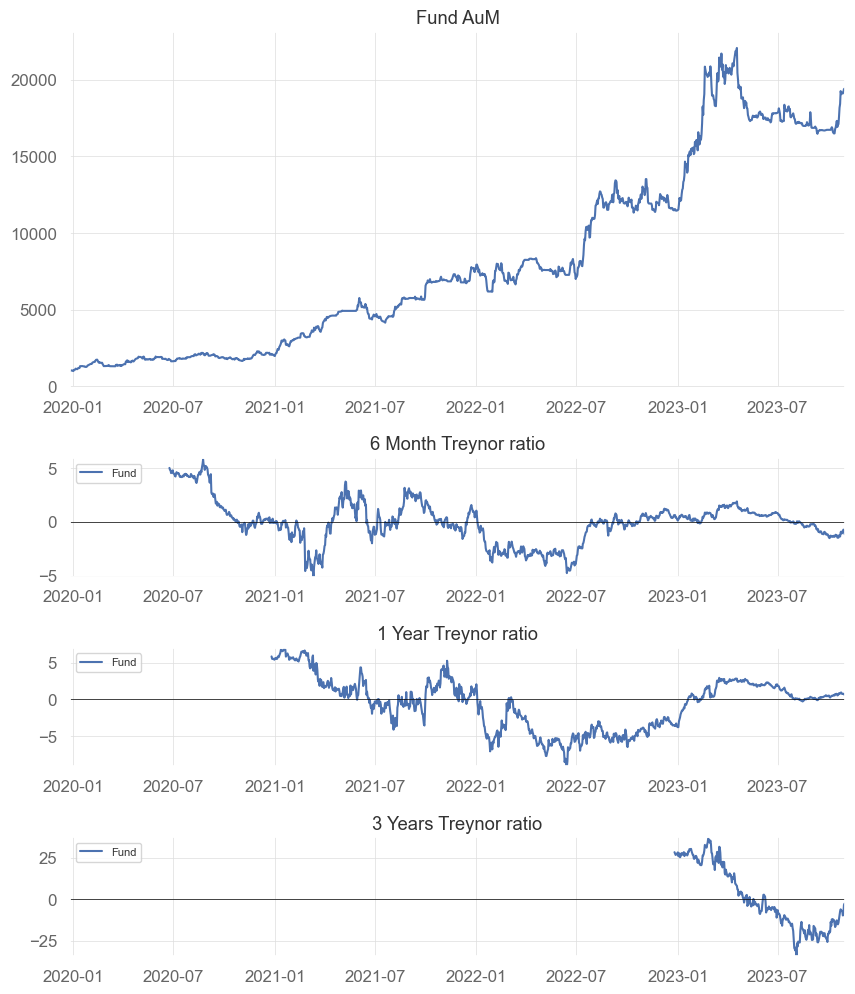

In [14]:
# Rolling Treynor ratio
print("Metric: Rolling Treynor ratio")

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")
btcDailyData = btcData.set_index("Date")

# Merge the data
df = pd.concat([fundDailyData.AuM, btcDailyData.Price, rfReturn.Price], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark", "RiskFreeReturn"]

treynor_6M = calcRollingTreynorRatio(dfReturn, datetime.timedelta(180))
treynor_1Y = calcRollingTreynorRatio(dfReturn, datetime.timedelta(365))
treynor_3Y = calcRollingTreynorRatio(dfReturn, datetime.timedelta(365*3))

# Plot the rolling Treynor ratio
subPlots = [treynor_6M,treynor_1Y,treynor_3Y]
plotTitle = ["Fund AuM", "6 Month Treynor ratio", "1 Year Treynor ratio", "3 Years Treynor ratio"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

Metric: Rolling Sortino ratio


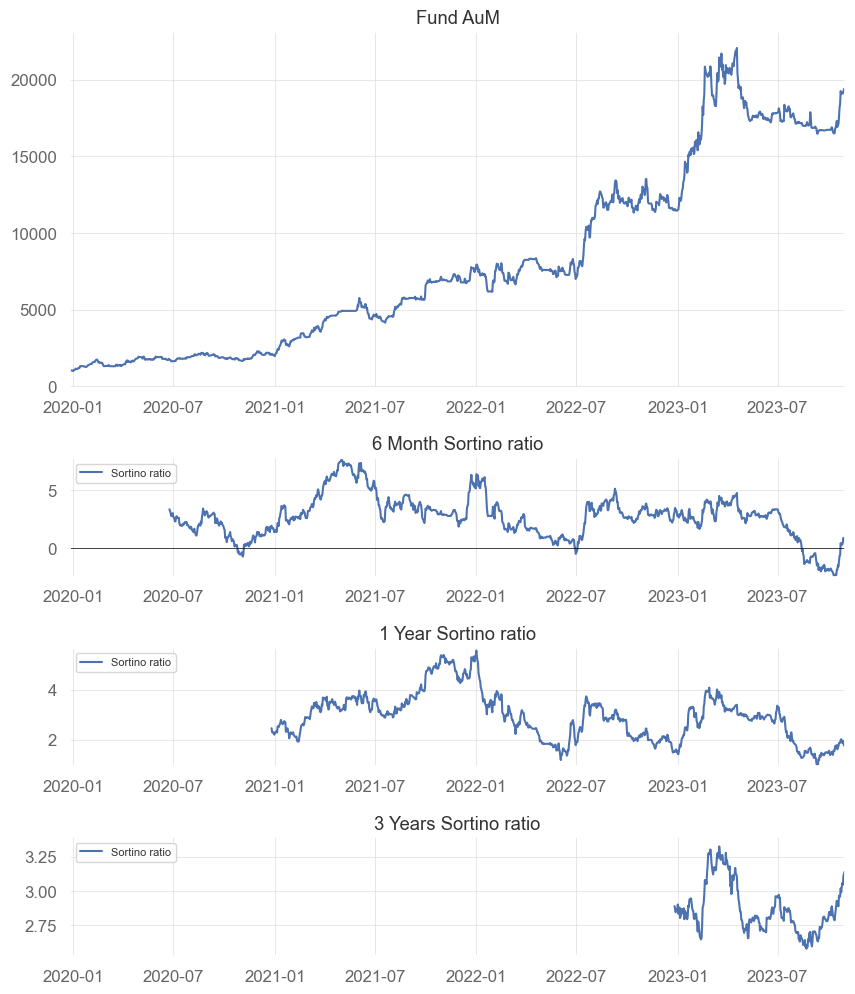

In [15]:
# Rolling Sortino ratio
print("Metric: Rolling Sortino ratio")

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")
btcDailyData = btcData.set_index("Date")

# Merge the data
df = pd.concat([fundDailyData.AuM, btcDailyData.Price, rfReturn.Price], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark", "RiskFreeReturn"]

sortino_6M = pd.DataFrame(qs.stats.rolling_sortino(dfReturn.Fund, rf = rfReturn.mean().iloc[0]/100., rolling_period=180).dropna())
sortino_6M.columns = ["Sortino ratio"]
sortino_1Y = pd.DataFrame(qs.stats.rolling_sortino(dfReturn.Fund, rf = rfReturn.mean().iloc[0]/100., rolling_period=365).dropna())
sortino_1Y.columns = ["Sortino ratio"]
sortino_3Y = pd.DataFrame(qs.stats.rolling_sortino(dfReturn.Fund, rf = rfReturn.mean().iloc[0]/100., rolling_period=3*365).dropna())
sortino_3Y.columns = ["Sortino ratio"]

# Plot the rolling Sortino ratio
subPlots = [sortino_6M,sortino_1Y,sortino_3Y]
plotTitle = ["Fund AuM", "6 Month Sortino ratio", "1 Year Sortino ratio", "3 Years Sortino ratio"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

Metric: Rolling sharpe ratio


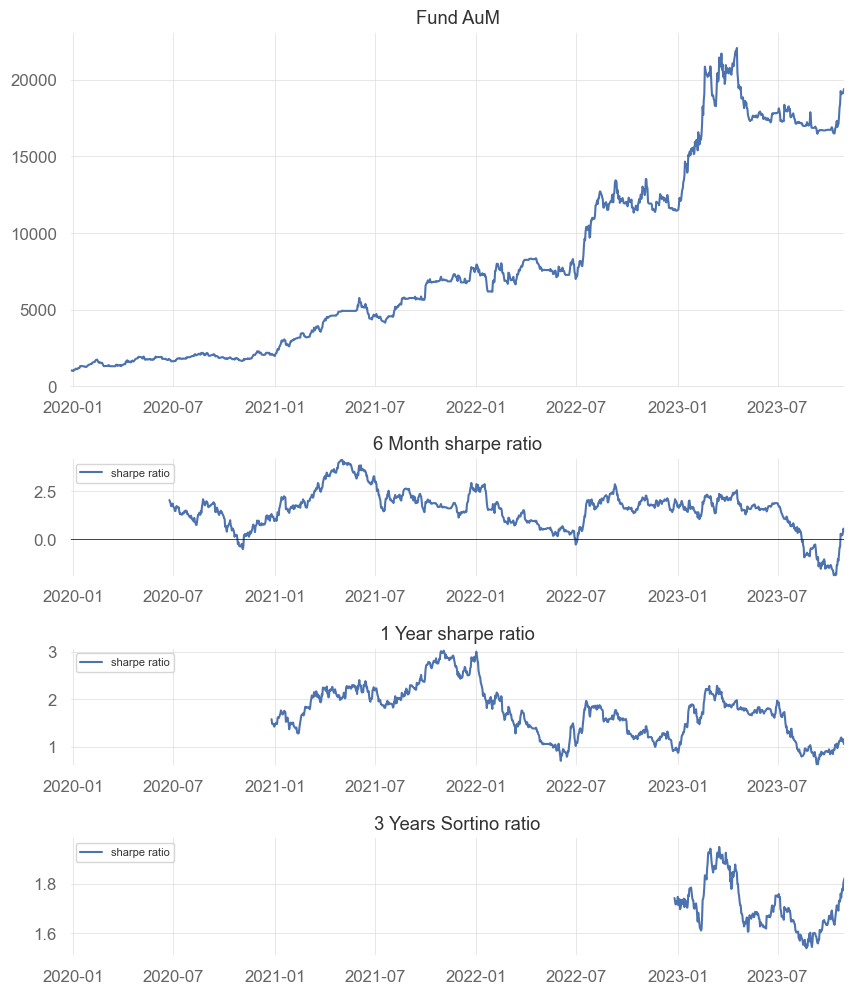

In [16]:
# Rolling Sharpe ratio
print("Metric: Rolling sharpe ratio")

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")
btcDailyData = btcData.set_index("Date")

# Merge the data
df = pd.concat([fundDailyData.AuM, btcDailyData.Price, rfReturn.Price], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark", "RiskFreeReturn"]

sharpe_6M = pd.DataFrame(qs.stats.rolling_sharpe(dfReturn.Fund, rf = rfReturn.mean().iloc[0]/100., rolling_period=180).dropna())
sharpe_6M.columns = ["sharpe ratio"]
sharpe_1Y = pd.DataFrame(qs.stats.rolling_sharpe(dfReturn.Fund, rf = rfReturn.mean().iloc[0]/100., rolling_period=365).dropna())
sharpe_1Y.columns = ["sharpe ratio"]
sharpe_3Y = pd.DataFrame(qs.stats.rolling_sharpe(dfReturn.Fund, rf = rfReturn.mean().iloc[0]/100., rolling_period=3*365).dropna())
sharpe_3Y.columns = ["sharpe ratio"]

# Plot the rolling sharpe ratio
subPlots = [sharpe_6M,sharpe_1Y,sharpe_3Y]
plotTitle = ["Fund AuM", "6 Month sharpe ratio", "1 Year sharpe ratio", "3 Years Sortino ratio"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

Metric: Rolling Sortino ratio


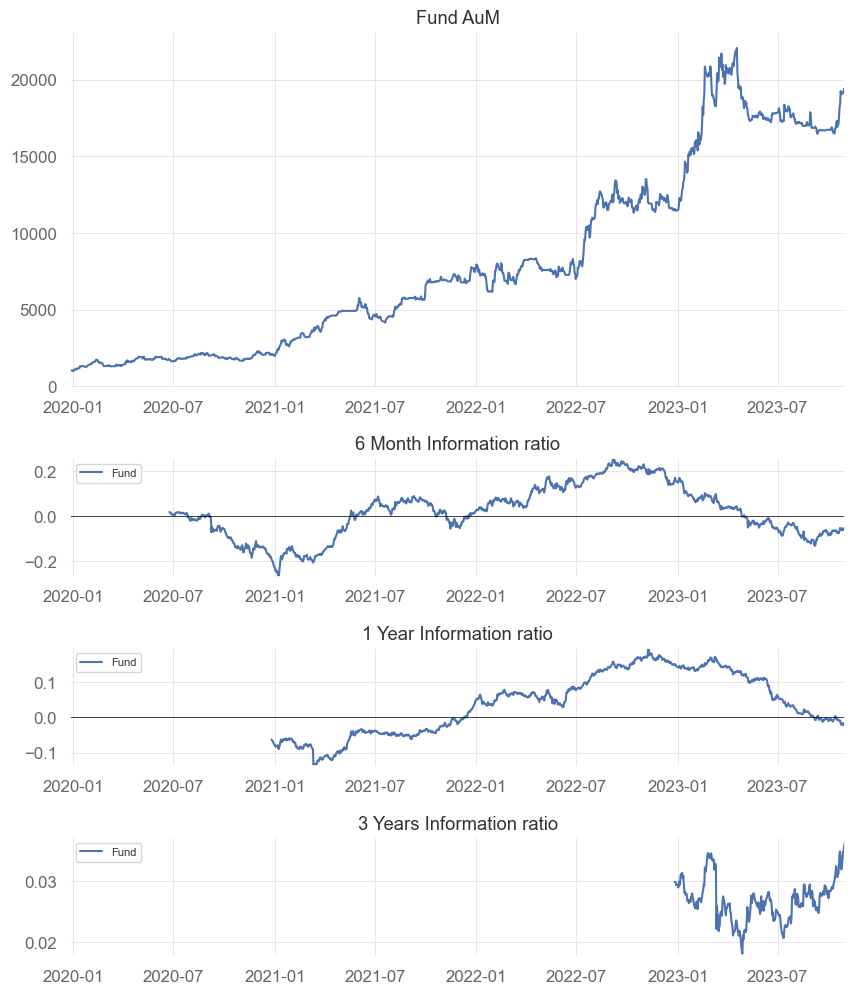

In [17]:
# Rolling information ratio
print("Metric: Rolling Information ratio")

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")
btcDailyData = btcData.set_index("Date")

# Merge the data
df = pd.concat([fundDailyData.AuM, btcDailyData.Price], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark"]

InformationRatio_6M = calcRollingInformationRatio(dfReturn, datetime.timedelta(days = 180))
InformationRatio_1Y = calcRollingInformationRatio(dfReturn, datetime.timedelta(days = 365))
InformationRatio_3Y = calcRollingInformationRatio(dfReturn, datetime.timedelta(days = 365 * 3))

# Plot the rolling Information ratio
subPlots = [InformationRatio_6M,InformationRatio_1Y,InformationRatio_3Y]
plotTitle = ["Fund AuM", "6 Month Information ratio", "1 Year Information ratio", "3 Years Information ratio"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

Metric: Standard deviation of returns


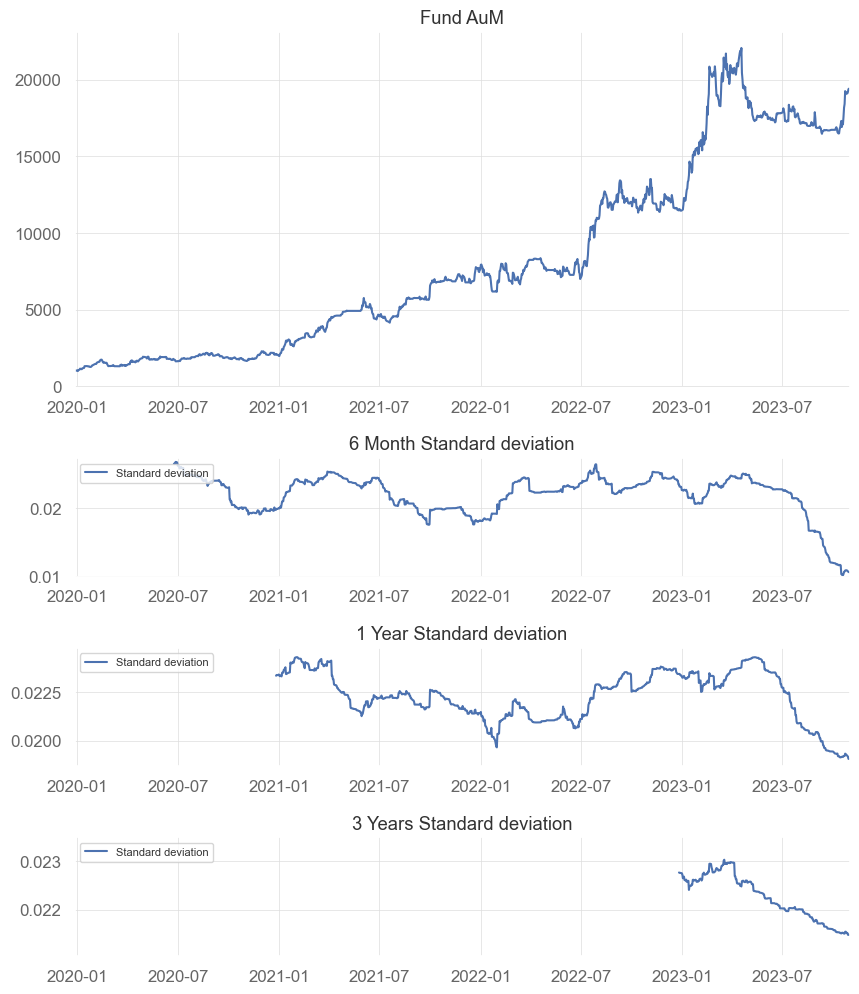

In [18]:
# Standard deviation of returns
print("Metric: Standard deviation of returns")
fundDailyData = f1_DailyAuM.set_index("Date")
fundDailyReturn = fundDailyData.pct_change(1).dropna()
fundDailyReturn

rollingSTD_6M = calcRollingSTD(fundDailyReturn, datetime.timedelta(180))
rollingSTD_1Y = calcRollingSTD(fundDailyReturn, datetime.timedelta(365))
rollingSTD_3Y = calcRollingSTD(fundDailyReturn, datetime.timedelta(365*3))

# Plot the rolling STD
subPlots = [rollingSTD_6M,rollingSTD_1Y,rollingSTD_3Y]
plotTitle = ["Fund AuM", "6 Month Standard deviation", "1 Year Standard deviation", "3 Years Standard deviation"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

Metric: Downside deviation


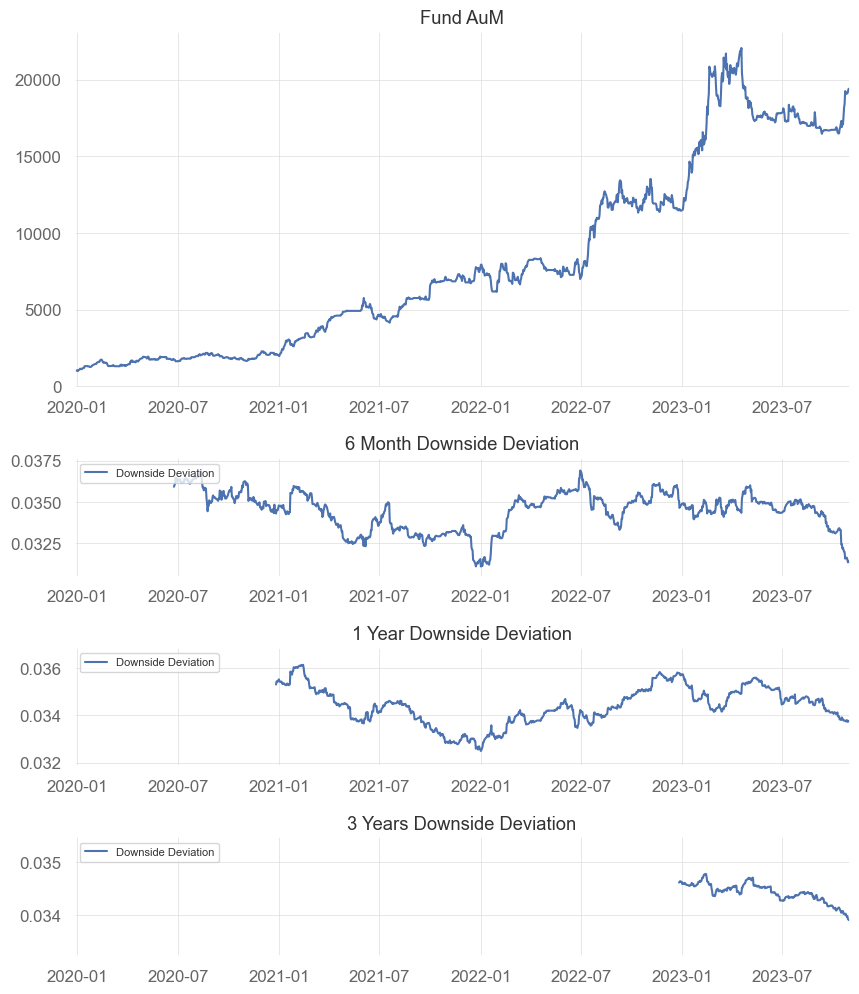

In [19]:
# Standard deviation of returns
print("Metric: Downside deviation")
fundDailyData = f1_DailyAuM.set_index("Date")
fundDailyReturn = fundDailyData.pct_change(1).dropna()
fundDailyReturn

minAccReturn = 0.01 # Minimum acceptable return

DownsideDeviation_6M = calcRollingDownsideDeviation(fundDailyReturn, datetime.timedelta(180),minAccReturn)
DownsideDeviation_1Y = calcRollingDownsideDeviation(fundDailyReturn, datetime.timedelta(365),minAccReturn)
DownsideDeviation_3Y = calcRollingDownsideDeviation(fundDailyReturn, datetime.timedelta(365*3),minAccReturn)

# Plot the rolling STD
subPlots = [DownsideDeviation_6M,DownsideDeviation_1Y,DownsideDeviation_3Y]
plotTitle = ["Fund AuM", "6 Month Downside Deviation", "1 Year Downside Deviation", "3 Years Downside Deviation"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

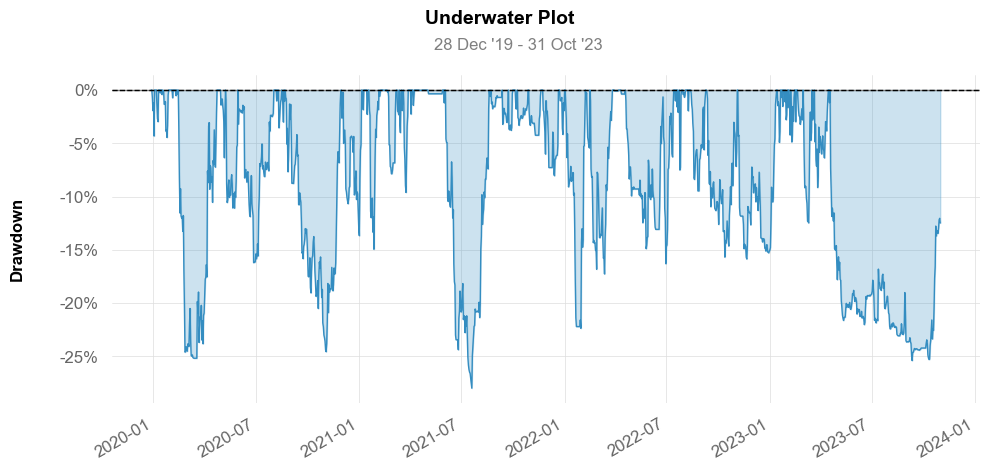

AuM                                                           
         start      valley         end days max drawdown 99% max drawdown
0   2019-12-28  2020-02-24  2020-03-13   77    -5.664439        -5.358551
1   2020-03-19  2020-05-10  2020-07-16  120    -7.961040        -6.446521
2   2020-07-18  2021-01-21  2021-02-13  211    -9.183167        -4.810549
3   2021-02-17  2021-02-23  2021-02-23    7    -4.545397        -0.606024
4   2021-02-25  2021-02-25  2021-03-02    6    -2.129706        -0.632763
5   2021-03-06  2021-03-22  2021-04-18   44    -4.251448        -3.131858
6   2021-04-23  2021-05-04  2021-05-04   12    -0.350866         0.009538
7   2021-05-29  2021-06-18  2021-06-22   25    -5.751215        -5.750402
8   2021-06-26  2021-07-05  2021-09-04   71    -4.126333        -3.084944
9   2021-09-12  2021-09-13  2021-09-20    9    -3.222072        -0.558415
10  2021-09-22  2021-09-24  2021-11-10   50    -3.600459        -2.591328
11  2021-11-17  2021-11-18  2021-11-21    5     0.402339         1.363787
12  2021-11-24  2021-12-04  2021-12-04   11    -2.971526        -2.122708
13  2021-12-11  2022-01-20  2022-01-22   43    -5.493120        -4.217452
14  2022-01-29  2022-02-17  2022-02-25   28    -6.486386        -3.646390
15  2022-02-27  2022-03-10  2022-03-31   33    -3.249260        -2.622378
16  2022-04-07  2022-04-08  2022-04-08    2     0.102250         0.833526
17  2022-04-12  2022-04-12  2022-04-12    1    -0.372329              NaN
18  2022-04-19  2022-04-21  2022-05-05   17    -2.654638        -2.356455
19  2022-05-14  2022-05-26  2022-06-12   30    -4.174027        -3.057632
20  2022-06-19  2022-07-25  2022-08-26   69    -7.509130        -6.526629
21  2022-08-29  2022-11-08  2022-11-10   74    -7.073758        -5.359770
22  2022-11-15  2023-04-19  2023-08-17  276    -7.351881        -3.829593
23  2023-08-21  2023-08-31  2023-09-27   38    -3.416814        -2.217059
24  2023-10-06  2023-10-17  2023-10-31   26    -2.278371        -1.352689

In [20]:
# Max drawDown
# Standard deviation of returns
fundDailyData = f1_DailyAuM.set_index("Date")
fundDailyReturn = fundDailyData.pct_change(1).dropna()
fundDailyReturn

qs.plots.drawdown(fundDailyReturn)
qs.stats.drawdown_details(fundDailyReturn)

Metric: tracking error


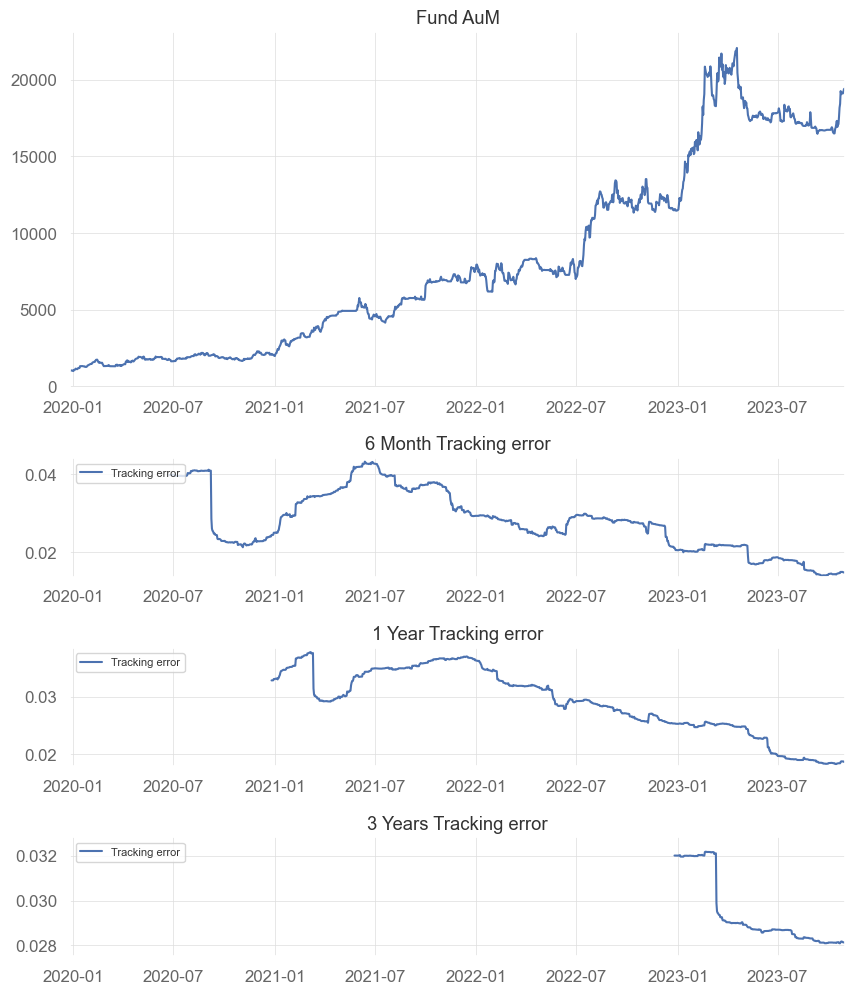

In [21]:
# Tracking error
print("Metric: tracking error")

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")
btcDailyData = btcData.set_index("Date")

# Merge the data
df = pd.concat([fundDailyData.AuM, btcDailyData.Price], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark"]

trackingError_6M = calcRollingTrackingError(dfReturn, datetime.timedelta(180))
trackingError_1Y = calcRollingTrackingError(dfReturn, datetime.timedelta(365))
trackingError_3Y = calcRollingTrackingError(dfReturn, datetime.timedelta(365*3))

# Plot the rolling STD
subPlots = [trackingError_6M,trackingError_1Y,trackingError_3Y]
plotTitle = ["Fund AuM", "6 Month Tracking error", "1 Year Tracking error", "3 Years Tracking error"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [22]:
# Alpha and beta of the fund
# Ref: https://www.allquant.co/post/linear-regression-finding-alpha-and-beta
print("Metric: Alpha and beta of a fund")

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")
btcDailyData = btcData.set_index("Date")

# Merge the data
df = pd.concat([fundDailyData.AuM, btcDailyData.Price, rfReturn.Price], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark", "RiskFreeReturn"]

# Find alpha and beta
y = np.array(dfReturn.Fund-dfReturn.Benchmark)
x = np.array(dfReturn.Benchmark-dfReturn.RiskFreeReturn)
x = np.expand_dims(x, axis=1)
model = LinearRegression()
model.fit(x, y)

print(f"Fund alpha: {model.intercept_}   |   beta: {model.coef_}")

Metric: Alpha and beta of a fund
Fund alpha: 0.0005940534235671012   |   beta: [-0.2488688]


In [6]:
# MPPM (Manipulation-Proof Performance measure)
print("Metric: MPPM")
# Making the monthly return/rates dataframe

# Get Fund data
dfTrades = loadTrades("./Data/Daily AuM - Trades_10.csv")
dfTrades["monthYear"] = dfTrades["sell_date"].dt.to_period("M")
dfTrades["Gen_AuM"] = dfTrades.pnl.expanding(min_periods=1).sum().add(1000)
dfTrades["FundReturn"] = dfTrades["Gen_AuM"].pct_change(1).fillna(0)

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Get BTC returns, also fill the missing dates
btcDailyData = btcData.set_index("Date")

# Get the Barclay hedge index data
barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
barclayReturns = barclayReturns[(btcDailyData.index[0] <= barclayReturns.Date)&(barclayReturns.Date <= btcDailyData.index[-1])].reset_index(drop=True).set_index("Date")

# Merge the data
df = pd.concat([btcDailyData.Price, barclayReturns.barclayReturn, rfReturn.Price], axis = 1).dropna()
df.columns = ["BTC","Barclay","RiskFree"]
df["monthYear"] = df.index
df["monthYear"] = df["monthYear"].dt.to_period("M")
df["BTCReturn"] = df[["BTC"]].pct_change(1).fillna(0)

# Make the dataframe consisting of monthly returns of fund, benchmark and risk free rate
dfMonthly = pd.DataFrame()
dfMonthly["FundReturn"] = pd.DataFrame(dfTrades.groupby(["monthYear"])["FundReturn"].apply(lambda x: x.add(1).prod()-1))
dfMonthly["BTCReturn"] = pd.DataFrame(df.groupby(["monthYear"])["BTCReturn"].apply(lambda x: (x.add(1).prod()-1)))
dfMonthly["RiskFreeRate"] = pd.DataFrame(df.groupby(["monthYear"])["RiskFree"].apply(lambda x: (x.iloc[-1])))
dfMonthly["BarclayHedge"] = pd.DataFrame(df.groupby(["monthYear"])["Barclay"].apply(lambda x: (x.iloc[-1])))
dfMonthly.dropna(inplace=True)

# Change the indexing to multi index 
dfMonthly.index = pd.MultiIndex.from_arrays([dfMonthly.index.year, dfMonthly.index.month], names = ["year", "month"])

# MPPM Calculation
sampleYear= dfMonthly.loc[2020]

print(calcMPPM(sampleYear.FundReturn, sampleYear.BarclayHedge, sampleYear.RiskFreeRate))

Metric: MPPM
0.03507252081234514


In [24]:
# Market timing
print("Market timing")


Market timing


In [25]:
# Security selection
print("Security selection")


Security selection


In [24]:
# CRP (Cross Product Ratio)
print("Metric: CRP ")

# Get Fund data
dfTrades = loadTrades("./Data/Daily AuM - Trades_10.csv")
dfTrades["monthYear"] = dfTrades["sell_date"].dt.to_period("M")
dfTrades["Gen_AuM"] = dfTrades.pnl.expanding(min_periods=1).sum().add(1000)
dfTrades["FundReturn"] = dfTrades["Gen_AuM"].pct_change(1).fillna(0)

# Make the dataframe consisting of monthly returns of fund, benchmark and risk free rate
dfMonthly = pd.DataFrame()
dfMonthly["FundReturn"] = pd.DataFrame(dfTrades.groupby(["monthYear"])["FundReturn"].apply(lambda x: x.add(1).prod()-1))
dfMonthly.dropna(inplace=True)

# Change the indexing to multi index 
dfMonthly.index = pd.MultiIndex.from_arrays([dfMonthly.index.year, dfMonthly.index.month], names = ["year", "month"])

# See if fund won or lost in the period
dfMonthly["Result"] = "-" # FIlling the rows with dummy values
dfMonthly["DoubleResult"] = "-" # FIlling the rows with dummy values

# Filling the rows with respect to median return of each year
for interval in dfMonthly.groupby(level=0):
    median = interval[1].FundReturn.median()
    j = 0
    for i,row in interval[1].iterrows():
        dfMonthly.loc[i,"Result"] = "W" if median<=row["FundReturn"] else "L"
        if j!=0:
            if (dfMonthly.loc[(i[0],i[1]-1),"Result"] == "L") and (dfMonthly.loc[(i[0],i[1]),"Result"] == "W"): dfMonthly.loc[i,"DoubleResult"] = "LW"
            if (dfMonthly.loc[(i[0],i[1]-1),"Result"] == "W") and (dfMonthly.loc[(i[0],i[1]),"Result"] == "L"): dfMonthly.loc[i,"DoubleResult"] = "WL"
            if (dfMonthly.loc[(i[0],i[1]-1),"Result"] == "L") and (dfMonthly.loc[(i[0],i[1]),"Result"] == "L"): dfMonthly.loc[i,"DoubleResult"] = "LL"
            if (dfMonthly.loc[(i[0],i[1]-1),"Result"] == "W") and (dfMonthly.loc[(i[0],i[1]),"Result"] == "W"): dfMonthly.loc[i,"DoubleResult"] = "WW"
        else: 
            dfMonthly.loc[i,"DoubleResult"] = None 
        j+=1

# Calculate CRP for every year
for interval in dfMonthly.groupby(level=0):
    t = interval[1]
    if (t[t.DoubleResult == "LW"].shape[0]+t[t.DoubleResult == "WL"].shape[0]) != 0: 
        CRP = (t[t.DoubleResult == "WW"].shape[0]+t[t.DoubleResult == "LL"].shape[0])/(t[t.DoubleResult == "LW"].shape[0]+t[t.DoubleResult == "WL"].shape[0])
        print(f"CRP Ratio for year {interval[0]} is: {np.round(CRP,2)}")
    else: 
        CRP = "Undefined"
        print(f"CRP Ratio for year {interval[0]} is: {CRP}")

Metric: CRP 
CRP Ratio for year 2019 is: Undefined
CRP Ratio for year 2020 is: 0.57
CRP Ratio for year 2021 is: 1.2
CRP Ratio for year 2022 is: 1.75
CRP Ratio for year 2023 is: 1.25


In [29]:
# Payoff ratio
print("Metric: Payoff ratio ")

# Get Fund data
dfTrades = loadTrades("./Data/Daily AuM - Trades_10.csv")
dfTrades["monthYear"] = dfTrades["sell_date"].dt.to_period("M")
dfTrades["Gen_AuM"] = dfTrades.pnl.expanding(min_periods=1).sum().add(1000)
dfTrades["FundReturn"] = dfTrades["Gen_AuM"].pct_change(1).fillna(0)

# Change the dataframe to contain only the PNLs
dfTrades = dfTrades[["sell_date","pnl"]]
dfTrades.columns = ["Date", "PNL"]
dfTrades = dfTrades.set_index("Date")

print(calcPayoffRatio(dfTrades))

Metric: Payoff ratio 
1.4443899864603342


In [30]:
# Hit rate
print("Metric: Hit rate")

# Get Fund data
dfTrades = loadTrades("./Data/Daily AuM - Trades_10.csv")
dfTrades["monthYear"] = dfTrades["sell_date"].dt.to_period("M")
dfTrades["Gen_AuM"] = dfTrades.pnl.expanding(min_periods=1).sum().add(1000)
dfTrades["FundReturn"] = dfTrades["Gen_AuM"].pct_change(1).fillna(0)

# Change the dataframe to contain only the PNLs
dfTrades = dfTrades[["sell_date","pnl"]]
dfTrades.columns = ["Date", "PNL"]
dfTrades = dfTrades.set_index("Date")

print(f"{calcHitRate(dfTrades)} %")

Metric: Hit rate
49.66828836797877 %


In [98]:
# Turnover rate
print("Metric: Turnover rate")

# Get Fund data
dfTrades = loadTrades("./Data/Daily AuM - Trades_10.csv")
dfTrades["monthYear"] = dfTrades["sell_date"].dt.to_period("M")
dfTrades["AuM"] = dfTrades.pnl.expanding(min_periods=1).sum().add(1000)
dfTrades["FundReturn"] = dfTrades["AuM"].pct_change(1).fillna(0)

dfTrades = dfTrades[["buy_price","sell_price","lot","sell_date","AuM"]].set_index("sell_date").sort_index()
dfTrades = dfTrades.iloc[-180:-1]
turnoverRate_6M = calcTurnOverRate(dfTrades)
print(f"6 month turnover ratio: {turnoverRate_6M}")


Metric: Turnover rate
6 month turnover ratio: 17894.86323781387


In [5]:
# Average holding time
print("Metric: Average holding time")

# Get Fund data
dfTrades = loadTrades("./Data/Daily AuM - Trades_10.csv")
dfTrades["monthYear"] = dfTrades["sell_date"].dt.to_period("M")
dfTrades["AuM"] = dfTrades.pnl.expanding(min_periods=1).sum().add(1000)
dfTrades["FundReturn"] = dfTrades["AuM"].pct_change(1).fillna(0)

dfTrades = dfTrades[["buy_price","sell_price","lot","sell_date","AuM"]].set_index("sell_date").sort_index()
dfTrades = dfTrades.iloc[-180:-1]
avgHoldingTime_6M = calcAvgHoldingTime(dfTrades)
print(f"6 month holding time: {avgHoldingTime_6M}")


Metric: Average holding time
6 month holding time: 0.010449926189145043


In [108]:
# Conditional Sharpe ratio
print("Metric: Conditional Sharpe ratio")

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")

fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)
RiskFreeMonthlyReturn =  rfReturn.Price.groupby(pd.Grouper(freq='M')).apply(lambda x: x.iloc[-1])

# Merge the data
df = pd.concat([fundMonthlyReturn, RiskFreeMonthlyReturn], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.dropna()
dfReturn.columns = ["Fund", "RiskFreeReturn"]

CShapre = calcConditionalSharpeRatio(fundMonthlyReturn, RiskFreeMonthlyReturn.mean(), .95, "parametric", "normal", 6)
print(f"Conditional Sharpe ratio with 95% confidence level: {CShapre}")

Metric: Conditional Sharpe ratio
Conditional Sharpe ratio with 95% confidence level: 65.36380817356833


In [111]:
# Excess return on VaR
print("Metric: Excess return on VaR")

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")

fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)
RiskFreeMonthlyReturn =  rfReturn.Price.groupby(pd.Grouper(freq='M')).apply(lambda x: x.iloc[-1])

# Merge the data
df = pd.concat([fundMonthlyReturn, RiskFreeMonthlyReturn], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.dropna()
dfReturn.columns = ["Fund", "RiskFreeReturn"]

CShapre = calcExcessReturnOnVaR(fundMonthlyReturn, RiskFreeMonthlyReturn.mean(), .95, "parametric", "normal", 6)
print(f"Conditional Sharpe ratio with 95% confidence level: {CShapre}")

Metric: Excess return on VaR
Conditional Sharpe ratio with 95% confidence level: 88.15910966383386


In [121]:
# Modified Sharpe ratio
print("Metric: Modified Sharpe ratio")

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")

fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)
RiskFreeMonthlyReturn =  rfReturn.Price.groupby(pd.Grouper(freq='M')).apply(lambda x: x.iloc[-1])

# Merge the data
df = pd.concat([fundMonthlyReturn, RiskFreeMonthlyReturn], axis = 1).dropna()

# Get the daily return of fund and BTC
dfReturn = df.dropna()
dfReturn.columns = ["Fund", "RiskFreeReturn"]

CShapre = calcModifiedSharpeRatio(fundMonthlyReturn, RiskFreeMonthlyReturn.mean(), .95, "parametric", "normal", 6)
print(f"Modified Sharpe ratio with 95% confidence level: {CShapre}")

Metric: Modified Sharpe ratio
Modified Sharpe ratio with 95% confidence level: -72.53130626651631


In [7]:
# Upside potential ratio
print("Metric: Upside potential ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)

print(f"Upside potential ratio for a 4% monthly return: {calcUpsidePotentialRatio(fundMonthlyReturn, .04)}")

Metric: Upside potential ratio
Upside potential ratio for a 4% monthly return: 3.170664352729582


In [8]:
# Omega ratio ratio
print("Metric: Omega ratio ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)

print(f"Omega ratio ratio for a 4% monthly return: {calcOmegaRatio(fundMonthlyReturn, .04)}")

Metric: Omega ratio ratio
Omega ratio ratio for a 4% monthly return: 3.0300385474214706


In [12]:
#  Bernardo and Ledoit ratio
print("Metric:  Bernardo and Ledoit ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)

print(f" Bernardo and Ledoit ratio on monthly return: {calcBernadoLedoitRatio(fundMonthlyReturn)}")

Metric:  Bernardo and Ledoit ratio
 Bernardo and Ledoit ratio on monthly return: 4.239130712688182


In [13]:
#  d ratio
print("Metric:  d ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)

print(f" d ratio on monthly return: {calcdRatio(fundMonthlyReturn)}")

Metric:  d ratio
 d ratio on monthly return: 0.14641908854440883


In [4]:
#  kappa3 ratio
print("Metric:  kappa3 ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)

print(f" Kappa ratio on monthly return: {calcKappa3Ratio(fundMonthlyReturn, .01)}")

Metric:  kappa3 ratio
 Kappa ratio on monthly return: 1.7104902717109853


In [7]:
#  Sterling ratio

print("Metric:  Sterling ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)


# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")

fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)
RiskFreeMonthlyReturn =  rfReturn.Price.groupby(pd.Grouper(freq='M')).apply(lambda x: x.iloc[-1])

nd = 5
print(f"Sterling ratio on monthly returns, assuming {nd} largest drawdowns: {calcSterlingRatio(fundMonthlyReturn, RiskFreeMonthlyReturn.mean(), nd)}")

Metric:  Sterling ratio
Sterling ratio on monthly returns, assuming 5 largest drawdowns: 0.31926229523037447


In [8]:
#  Burke ratio
print("Metric: Burke ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)
fundMonthlyAuM = fundDailyData.AuM.groupby(pd.Grouper(freq='M')).apply(lambda x: x.iloc[-1])

print(f"Burke ratio on monthly returns: {calcBurkeRatio(fundDailyData.AuM.pct_change(1),fundMonthlyReturn, RiskFreeMonthlyReturn.mean())}")

Metric: Burke ratio
Burke ratio on monthly returns: -0.5720788696404608


In [86]:
#  Adjusted sharpe ratio
print("Metric:  Adjusted sharpe ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)

# Get the risk free returns, Also, fill the missing dates
rfReturn = loadRiskFreeRate("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv").sort_values("Date", ascending=True, ignore_index=True).set_index("Date") 
idx = pd.date_range(rfReturn.index.min(),rfReturn.index.max())
rfReturn = rfReturn.reindex(idx, fill_value=np.nan)
rfReturn = rfReturn.ffill()

# Process the indexes for merging
fundDailyData = f1_DailyAuM.set_index("Date")

fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)
RiskFreeMonthlyReturn =  rfReturn.Price.groupby(pd.Grouper(freq='M')).apply(lambda x: x.iloc[-1])

print(f"Adjusted sharpe ratio on monthly returns: {calcAdjustedSharpeRatio(fundMonthlyReturn, RiskFreeMonthlyReturn.mean())}")

Metric:  Adjusted sharpe ratio
Adjusted sharpe ratio on monthly returns: 0.35676765705199087


In [87]:
#  Prospect ratio
print("Metric:  Prospect ratio")

fundDailyData = f1_DailyAuM.set_index("Date")
fundMonthlyReturn = fundDailyData.AuM.pct_change(1).dropna().groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1)

print(f"Burke ratio on monthly returns: {calcBurkeRatio(fundDailyData.AuM.pct_change(1),fundMonthlyReturn, .05)}")

Metric:  Prospect ratio
Burke ratio on monthly returns: -1.734767108546136


In [9]:
from performanceClass import performanceEval
import pprint

# Get the data
returns = getDataVisionTrack("./Data/Vision track fund data/VisionTrack by Vision Hill Group.html").iloc[0,3:]
returns = returns.str.replace("%","").astype(float).div(100)

# Change index of the returns data
months = []
dateEnd = datetime.date(2023, 12, 1)    
current = datetime.date(2013, 7, 1)    
while current <= dateEnd:
    months.append(current)
    current += relativedelta(months=1)  
months = months[::-1]
months = pd.to_datetime(months)

returns.index = months
returns = returns.sort_index(ascending=True)
returns.index = returns.index.to_period('M').to_timestamp('M') # Change first of the month date to end of the month

# Getting the monthly risk free rates
rf = loadRiskFreeRate("./Data/United States 5-Year Bond Yield Historical Data monthly long term.csv").set_index("Date")
monthlyRF = rf.groupby(pd.Grouper(freq='M')).apply(lambda x: np.power(1+x.mean(),1/12)-1).Price

# Getting the benchmark returns
barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls").set_index("Date")
barclayReturns.index = barclayReturns.index.to_period('M').to_timestamp('M') # Change first of the month date to end of the month
barclayReturns = barclayReturns.barclayReturn

# Getting the AuM
fundAuM = returns.dropna().add(1).cumprod()

# The series should contain the same indexes. Add all the series to a single dataframe, then drop rows containing nan.
tmpDf = pd.concat([returns,barclayReturns,fundAuM, monthlyRF], axis = 1).dropna()
returns = tmpDf.iloc[:,0]
barclayReturns = tmpDf.iloc[:,1]
fundAuM = tmpDf.iloc[:,2]
monthlyRF = tmpDf.iloc[:,3]

# Defining the minimum acceptable return and confidence level
MAR = .1
confLvL = .95

performanceObj = performanceEval(returns, monthlyRF, barclayReturns, fundAuM, MAR, confLvL)
pprint.pprint(performanceObj.metrics)

{"Jensen's alpha": 0.037,
 'adjusted Sharpe ratio': 0.18,
 'burke ratio': 0.01,
 'calmar ratio': 0.208,
 'conditional Sharpe ratio': 0.094,
 'cross product ratio': 1.429,
 'd ratio': 0.555,
 'downside deviation': 0.233,
 'excess return on VaR (Generalized Sharpe ratio)': 0.121,
 'information ratio': 0.175,
 'kappa 3 ratio': -0.501,
 'max drawdown': -0.768,
 'modified Sharpe ratio': -0.113,
 'net growth rate': 1.578,
 'omega ratio': 1.033,
 'prospect ratio': -0.504,
 'sharpe ratio': 0.185,
 'sortino ratio': 0.415,
 'standard deviation of returns': 0.219,
 'sterling calmar ratio': 0.05,
 'sterling ratio': 0.052,
 'tracking error': 0.21,
 'treynor ratio': 0.009,
 'ulcer index': 201.304,
 'up/down capture rate': -1.864,
 'upside potential ratio': 1.444,
 'win rate': 0.536}
